# Recommendation 3: Spectral Parameterization


### Issue

Picking a model to fit to your raw power spectra involves giving specifying settings with which you wish your model to be fit. These settings should be carefully considered, as they have the possibility of changing your resulting parameter estimates. Once fixed, settings can also be subjected to sensitivity testing to examine whether, and which, model settings have the greatest effect on results. 

### Solution

Here, we provide general guidelines for the model settings that tend to be most sensitive to imaging modality, individual, noise, etc. 

These guidelines include:
- Choosing a frequency range for model fitting
- Deciding whether or not to fit with a knee
- How many oscillations to fit
- What type of threshold to use for estimating a noise floor

### Related Work

The following papers include discussion of this topic:

- [LINK](LINK), AUTHORS, YEAR

### Related Discussion / Examples

The following examples discuss related topics:
-  [LINK](LINK), DESCRIPTION

In [20]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import fooof

from neurodsp.sim import sim_combined, sim_knee, sim_peak_oscillation
from neurodsp.spectral import compute_spectrum
from neurodsp.plts.time_series import plot_time_series
from neurodsp.utils import create_times, set_random_seed

In [2]:
# Add path and import custom code for the project
import sys
sys.path.append('code')

### Settings

In [3]:
import seaborn as sns
sns.set_context('poster')

In [42]:
# Set random seed
set_random_seed(42)

In [43]:
# Set whether to save out figures
SAVE_FIG = False

### Picking a frequnecy range for fitting

#### Generate a timeseries & get PSD

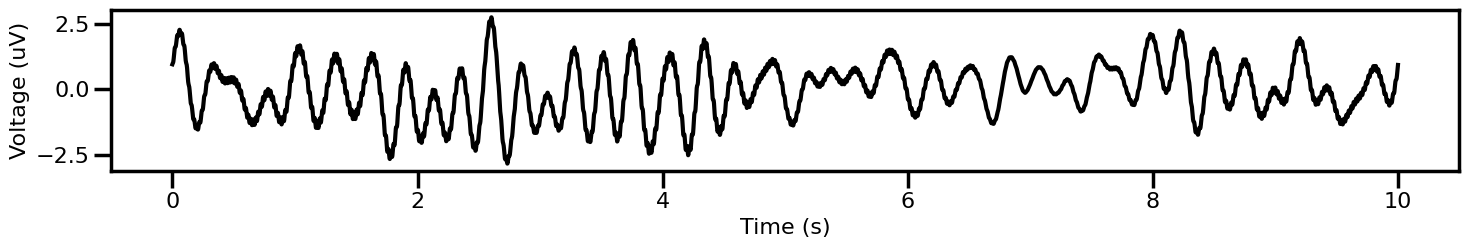

In [44]:
## Simulate timeseries as a combination of aperiodic and periodic components
sim_components = {'sim_knee': {'exponent1' : 0, 'exponent2':-5, 'knee':10},
                   'sim_oscillation': [{'freq' : 4}, {'freq' : 50}]}
fs = 1000
n_seconds = 10
ap_sig = sim_knee(n_seconds, fs,**sim_components['sim_knee'])
sig = sim_peak_oscillation(ap_sig, fs, freq=sim_components['sim_oscillation'][0]['freq'], bw=1, height=3)
sig = sim_peak_oscillation(sig, fs, freq=sim_components['sim_oscillation'][1]['freq'], bw=0.5, height=7)

times = create_times(n_seconds=n_seconds, fs=fs)
plot_time_series(times, sig)

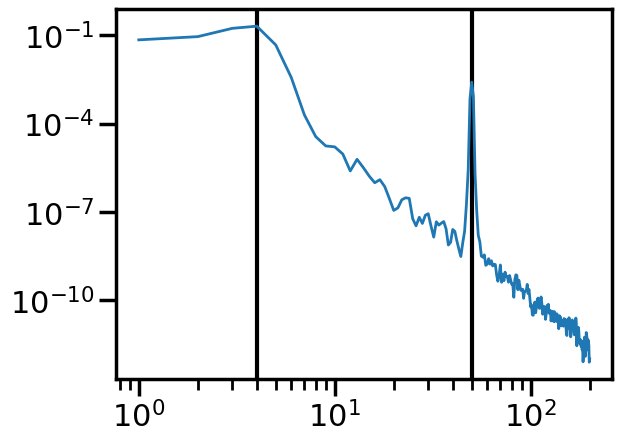

In [45]:
## Compute the power spectrum using Welch's 
freqs, powers = compute_spectrum(sig, fs=fs, f_range=(0.1,200), avg_type='median', nperseg=fs, noverlap=fs/2)

plt.axvline(sim_components['sim_oscillation'][0]['freq'], color='k')
plt.axvline(sim_components['sim_oscillation'][1]['freq'], color='k')
plt.loglog(freqs,powers, linewidth=2)

#### Fit the power spectrum with different frequency ranges

Fitting with a range which comfortably covers the frequencies that oscillations span across will allow for greater certainty that these oscillations actually will be captured (first plot).

However, it is notable that even if you are assured that your oscillations are being appropriately modeled, the frequnecy range for aperiodic slope estimation still makes a difference-- in the plot above, our model fitting was between 1 and 100 Hz, with an exponent estimate of 4.7. How do you think this might change if we fit the model on a wider range, between 1 and 200 Hz (well outside our range of oscillations)? See the exponent estimate below (middle plot). 

Similarly, the exponent estimate can vary if oscillations are not suitably captured-- which might happen if your range of fitting is too narrow (third plot). The model slope is skewed here because the oscillations are not modeled as peaks above the aperiodic slope. They pull the aperiodic fit such that it cuts through the oscillatory peaks, instead of being nestled neatly under the peaks.

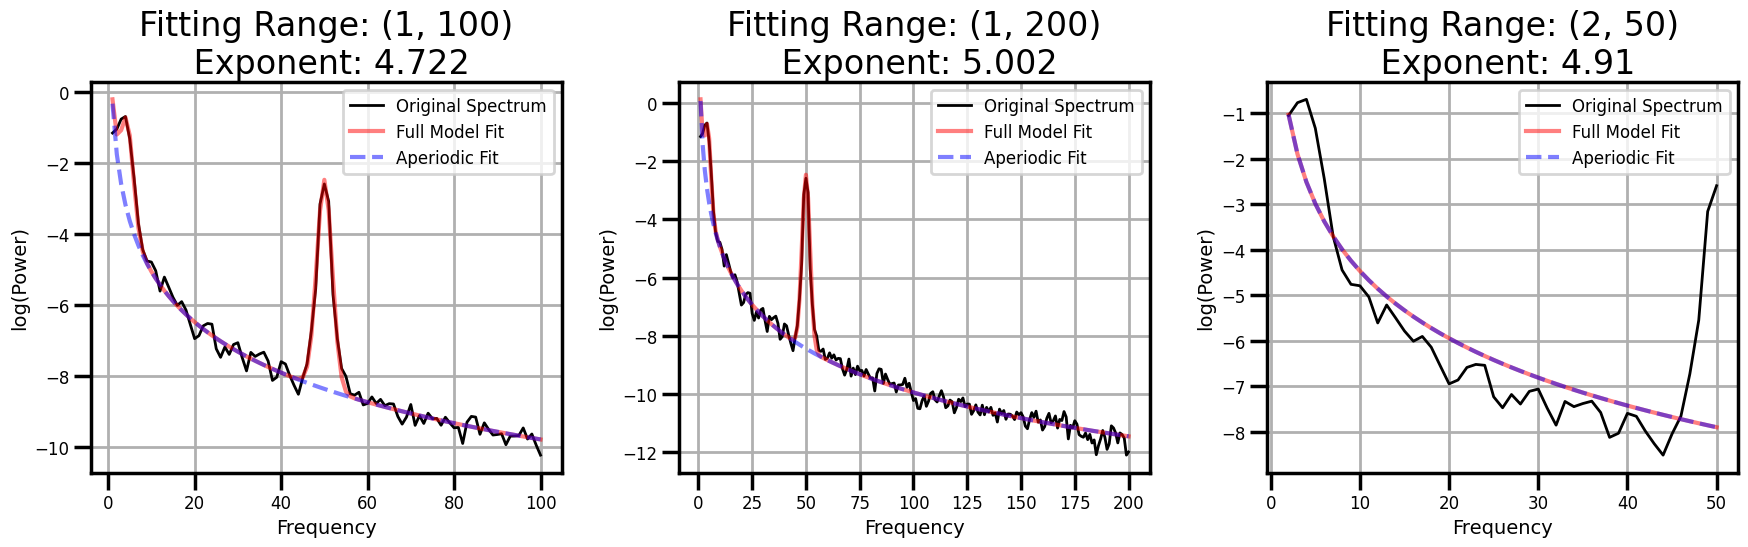

In [46]:
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

init_settings = {'peak_width_limits':(2,12), 'peak_threshold':2.5}

ax_dict = {0:{'freq_range':(1,100)}, 1: {'freq_range':(1,200)}, 2:{'freq_range':(2,50)}}

for i in ax_dict.keys():
    fit_settings = ax_dict[i]
    fm = fooof.FOOOF(**init_settings)
    fm.fit(freqs=freqs, power_spectrum=powers, **fit_settings)
    exp = np.round(fm.get_results().aperiodic_params[1], decimals=3)
    frange = ax_dict[i]['freq_range']
    fm.plot(ax=ax[i])
    ax[i].set_title(f'Fitting Range: {frange}\n Exponent: {exp}')


The tolerance for fitting oscillatory peaks at the edge of your fitting range can additionally be modified using the hidden parameter _bw_std_edge, which has a default value of 1. This parameter is in units of std deviation, and drops oscillatory peaks if they are detected too close to the edge of the spectrum (to prevent fitting of edge artifacts).

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 50 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -0.9335, 3.9803                                          
                                                                                                  
                                       1 peaks were found:                                        
          

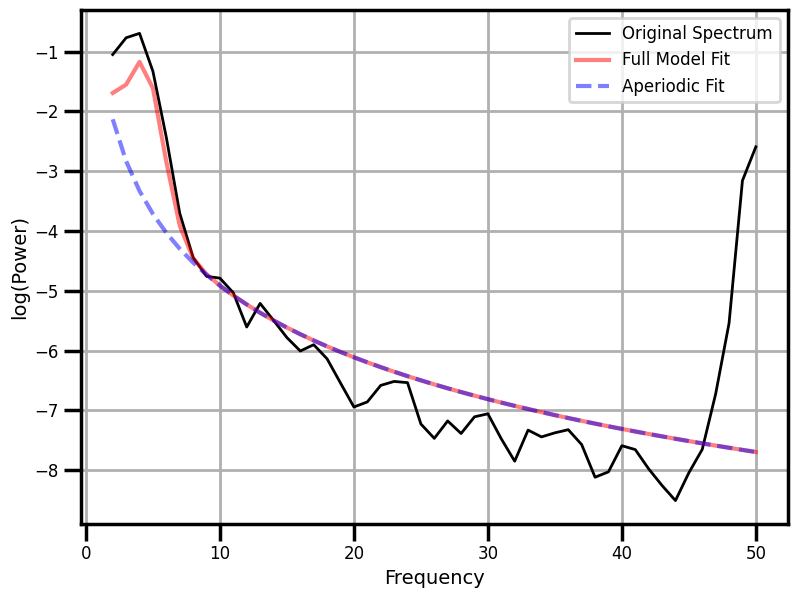

In [47]:

fit_settings = {'freq_range':(2,50)}

fm = fooof.FOOOF(**init_settings)
fm._bw_std_edge = 0.5

fm.fit(freqs=freqs, power_spectrum=powers, **fit_settings)
fm.report()

### SECTION II TITLE

### Conclusion

<>